In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import nltk
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Data Preprocessing

In [2]:
from tensorflow.keras.datasets import reuters
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer

In [3]:
(X_train, y_train), (X_test, y_test) = reuters.load_data() # skip_top=100)
print(X_train.size)
print(X_test.size)

8982
2246


In [4]:
x = X_train[0]
y = y_train[0]
print(x)
print(y)

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3


In [5]:
reverse_index = {v : k for (k, v) in reuters.get_word_index().items()}
NUM_OF_WORDS = len(reverse_index) + 3

In [6]:
# skip "padding", "start of sequence", and "unknown"
decoded_x = ' '.join([reverse_index.get(i - 3, '?') for i in x])
decoded_x

'? mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

Building a __validation__ set:

In [7]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_index, test_index in split.split(X_train, y_train):
    X_train_set = X_train[train_index]
    y_train_set = y_train[train_index]
    X_valid_set = X_train[test_index]
    y_valid_set = y_train[test_index]

In [8]:
print(X_train_set.size)
print(X_valid_set.size)

7634
1348


Glance at the __categories__:

In [9]:
unique, counts = np.unique(y_train_set, return_counts=True)
df = pd.DataFrame({'label':unique, 'docs':counts})
df.set_index('label', inplace=True)
df.head(5)

,docs
label,
0,47
1,367
2,63
3,2685
4,1657


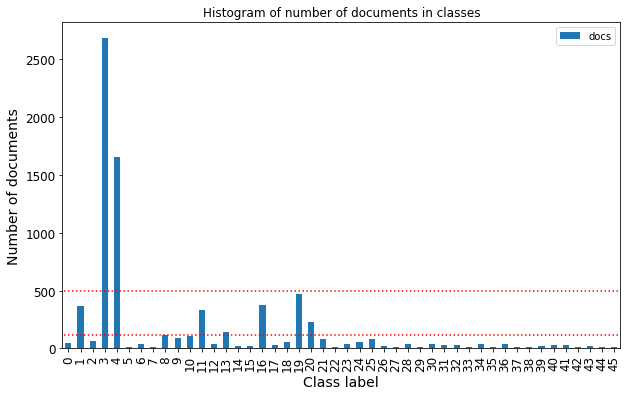

In [10]:
df.plot(kind='bar', figsize=(10, 6))
plt.plot([-1 , 46], [120, 120], "r:") 
plt.plot([-1 , 46], [500, 500], "r:") 
plt.title('Histogram of number of documents in classes')
plt.ylabel('Number of documents')
plt.xlabel('Class label')
plt.show()

In [11]:
group_names = ['Small', 'Medium', 'Large']
bins = [0, 120, 500, 3000]
df['size'] = pd.cut(df['docs'], bins, labels=group_names, include_lowest=True)
df.head()

,docs,size
label,,
0,47,Small
1,367,Medium
2,63,Small
3,2685,Large
4,1657,Large


Text(0.5, 0, 'Class size')

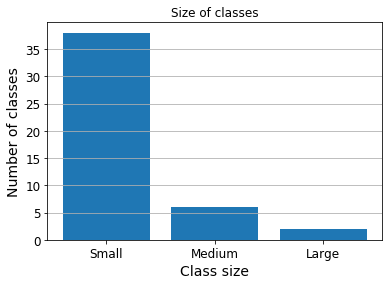

In [12]:
plt.bar(group_names, df['size'].value_counts())
plt.gca().yaxis.grid(True)
plt.title('Size of classes')
plt.ylabel('Number of classes')
plt.xlabel('Class size')

__Important__: There are two classes, which are significantly large, then others. The size of the classes should be more balanced to escape the bias. 

In [13]:
class MultinomialVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, words_count): # no *args or **kargs
        self.words_count = words_count
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        results = np.zeros(shape=(len(X), self.words_count))
        for i, x in enumerate(X):
            results[i, x] += 1.0
        return results

In [14]:
class BernoulliVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, words_count): # no *args or **kargs
        self.words_count = words_count
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        results = np.zeros(shape=(len(X), self.words_count))
        for i, x in enumerate(X):
            results[i, x] = 1.0
        return results

In [15]:
vector_pipeline = Pipeline([
        ('vectorizer', BernoulliVectorizer(words_count=NUM_OF_WORDS)),
        #('std_scaler', StandardScaler()),
        ('normalizer', Normalizer(norm='l1'))
    ])

In [16]:
%%time
X_train_set = vector_pipeline.fit_transform(X_train_set)
X_valid_set = vector_pipeline.fit_transform(X_valid_set)

Wall time: 4.45 s


## Model Selection

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR, SVC

In [23]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

In [34]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, cross_validate

In [25]:
%%time
lr = LogisticRegression(C=0.01, solver='liblinear')
lr.fit(X_train_set, y_train_set)

Wall time: 3.62 s


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
lr_mse = mean_squared_error(y_valid_set, lr.predict(X_valid_set))
lr_rmse = np.sqrt(lr_mse)
lr_rmse

10.890846345653266

In [27]:
print(lr.predict([X_train_set[2]]))
print(y_train_set[2])
print()
print(lr.predict([X_valid_set[3]]))
print(y_valid_set[3])

[3]
3

[3]
20


In [ ]:
%%time
scores = cross_validate(lr, X_train_set, y_train_set, cv=3, 
                        scoring=['accuracy', 'precision_micro', 'recall_micro', 'f1_micro'], 
                        return_train_score=True)
scores

In [ ]:
%%time
ovo_clf = OneVsOneClassifier(LogisticRegression(C=0.01, solver='liblinear'))
ovo_clf.fit(x_train[:1000], y_train[:1000])
ovo_clf.predict([x_train[0]])

In [20]:
%%time
ovr_lr = OneVsRestClassifier(LinearRegression())
ovr_lr.fit(X_train_set[:1000], y_train_set[:1000])
ovr_lr.predict([X_train_set[3]])

Wall time: 3min 15s


array([11], dtype=int64)

In [29]:
len(lr.estimators_)

AttributeError: 'LogisticRegression' object has no attribute 'estimators_'

In [ ]:
len(ovo_clf.estimators_)

In [ ]:
sgd_clf.decision_function([x_train[0]])

In [ ]:
scores = cross_val_score(lr, df_prep, labels, scoring="neg_mean_squared_error", cv=10)
lr_rmse_scores = np.sqrt(-scores)
display_scores(lr_rmse_scores)

In [ ]:
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

In [ ]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

In [ ]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 